# Segmentation model Solar Panel

Usage.

Please note the steps are for a windows computer, not linux environment, since the computer with GPU capabilities is using Windows.

1. Usage, please install VsCode and the Jupyter plugin. 
2. Make sure you have install virtual environment, if not, please execute: !pip install virtualenv
3. Once installed, press Ctrl+Shift+P , select Venv , and create a virtual environment. 

In [1]:
# If it's the first time, please uncomment the following line and a warning pop up window is going to appear, click on install for ipykernel package
# If for the first time it will take a lot of minutes.

# Recommendation: Execute on terminal and then set the kernel. 

# Uncomment below: 

# python -m venv .venv 
# .venv\Scripts\activate  
# pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu116!
# pip install -r requirements.txt


Data loading from folders

In [2]:
from pathlib import Path
import os

def load_files(folder_route: str):
    dir_path = Path(folder_route)
    folderContent = [os.path.join(dir_path, fn) for fn in next(os.walk(dir_path))[2]]
    return folderContent


TRAIN_IMAGE_DIR = './dataset/train/images/'
TRAIN_MASK_DIR = './dataset/train/masks/'

TEST_IMAGE_DIR = './dataset/test/images/'
TEST_MASK_DIR = './dataset/test/masks/'

folder_train_image_content = load_files(TRAIN_IMAGE_DIR)
folder_train_mask_content = load_files(TRAIN_MASK_DIR)
folder_test_image_content = load_files(TEST_IMAGE_DIR)
folder_test_mask_content = load_files(TEST_MASK_DIR)

print('Path: train/images, size: ',len(folder_train_image_content))
print('Path: train/masks, size: ',len(folder_train_mask_content))
print('Path: test/images, size: ',len(folder_test_image_content))
print('Path: test/masks, size: ',len(folder_test_image_content))

Path: train/images, size:  103
Path: train/masks, size:  103
Path: test/images, size:  10
Path: test/masks, size:  10


## Transformations and data loaders

In [3]:
from scripts.data_loader import load_and_transform

train_loader, val_loader, train_ds, train_val_ds, test_loader = load_and_transform(TRAIN_IMAGE_DIR,
 TRAIN_MASK_DIR,TEST_IMAGE_DIR, TEST_MASK_DIR)


c:\Users\carlo\Documents\Master\MasterTFM\model\.venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Segmentation model

In [4]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device {device}')


Using device cuda


In [5]:
import albumentations as A  
from albumentations.pytorch import ToTensorV2
from scripts.segmentation_net import SolarPanelModel
from torch.utils.data import DataLoader
import cv2
import pytorch_lightning as pl
import logging
import torch
import numpy as np

model = SolarPanelModel("unet", "efficientnet-b7","imagenet", in_channels=3, out_classes=1)

trainer = pl.Trainer(
    gpus=1, 
    max_epochs=5,
)

trainer.fit(
    model, 
    train_dataloaders=train_loader, 
    val_dataloaders=val_loader,
)

# run validation dataset
valid_metrics = trainer.validate(model, dataloaders=val_loader, verbose=False)
print(valid_metrics)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type              | Params
----------------------------------------------
0 | model   | Unet              | 67.1 M
1 | loss_fn | BCEWithLogitsLoss | 0     
----------------------------------------------
67.1 M    Trainable params
0         Non-trainable params
67.1 M    Total params
268.381   Total estimated model params size (MB)


Validation sanity check:   0%|          | 0/2 [00:00<?, ?it/s]

c:\Users\carlo\Documents\Master\MasterTFM\model\.venv\lib\site-packages\pytorch_lightning\trainer\data_loading.py:111: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


c:\Users\carlo\Documents\Master\MasterTFM\model\.venv\lib\site-packages\pytorch_lightning\trainer\data_loading.py:111: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 4: 100%|██████████| 103/103 [00:38<00:00,  2.67it/s, loss=0.0692, v_num=12, valid_per_image_iou=0.939, valid_dataset_iou=0.940, train_per_image_iou=0.974, train_dataset_iou=0.974]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[{'valid_per_image_iou': 0.9385064244270325, 'valid_dataset_iou': 0.940499484539032}]


## Test metrics

In [6]:
# run test dataset
test_metrics = trainer.test(model, dataloaders=test_loader, verbose=False)
print(test_metrics)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\carlo\Documents\Master\MasterTFM\model\.venv\lib\site-packages\pytorch_lightning\trainer\data_loading.py:453: UserWarning: Your `test_dataloader` has `shuffle=True`,it is strongly recommended that you turn this off for val/test/predict dataloaders.
  rank_zero_warn(
c:\Users\carlo\Documents\Master\MasterTFM\model\.venv\lib\site-packages\pytorch_lightning\trainer\data_loading.py:111: UserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 100%|██████████| 10/10 [00:00<00:00, 11.59it/s]
[{'test_per_image_iou': 0.9681777358055115, 'test_dataset_iou': 0.9685407280921936}]


## Visualize predictions.

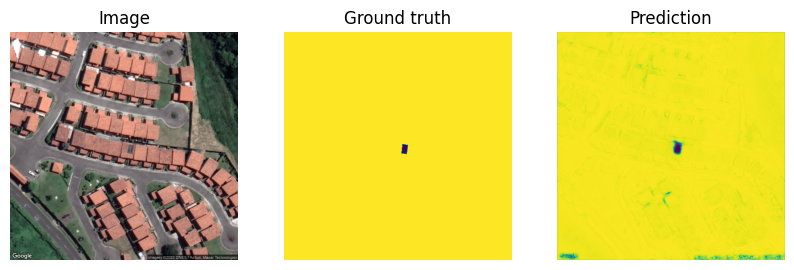

In [11]:
import torch
import matplotlib.pyplot as plt

batch= next(iter(test_loader))
with torch.no_grad():
    model.eval()
    logits = model(batch["image"])
pr_masks = logits.sigmoid()

for image, gt_mask, pr_mask in zip(batch["image"], batch["mask"], pr_masks):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(image.numpy().transpose(1, 2, 0))  # convert CHW -> HWC
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(gt_mask.numpy().squeeze()) # just squeeze classes dim, because we have only one class
    plt.title("Ground truth")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pr_mask.numpy().squeeze()) # just squeeze classes dim, because we have only one class
    plt.title("Prediction")
    plt.axis("off")

    plt.show()